# 프로젝트: 한국어 데이터로 챗봇 만들기

## 1. 라이브러리 설치

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


## 2. 데이터셋 가져오기

In [2]:
root_dir = os.getcwd()

# path_to_dataset = os.path.join(root_dir, "ChatbotData.csv")
path_to_dataset = "data/ChatbotData.csv"

data = pd.read_csv(path_to_dataset)

data.sample(10)

,Q,A,label
10012,사랑할수록 집착해,상대방이 싫어할수도 있어요.,2
492,나 무시하는 사람 짜증나,무시하세요.,0
11109,좋아하는 사람에게 요리를 해주면 좋아할까?,맛이 없든 있든 좋을 것 같아요.,2
4810,택시비 너무 비싸,후회해도 늦었어요.,0
6880,아침에 벌떡 일어났네.,안 좋은 꿈이라도 꿨나봅니다.,1
10169,썸 타고 싶어,먼저 다가가 보세요.,2
3139,여드름 짰어,손으로 만지지 마세요.,0
712,남자 보통 어디서 만나,소개팅 시켜달라고 말해보세요.,0
7075,여친이랑 헤어진지 1년째인데 아직도 못잊네.,언젠간 결정을 내려야하는 시기가 올 거예요.,1
6858,아직도 남았나봐,미련이 남지 않았길 발바니다.,1


label의 의미 : 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링

## 3. 데이터 전처리

In [3]:
# 결측치 확인

print(data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


In [4]:
# 전처리 함수
def preprocess_sentence(sentence):

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (ㄱ-ㅎ, ㅏ-ㅣ, 가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣\.\?\!,]", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [5]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_answer():

  inputs, outputs = [], []

  for i in range(len(data)):
      question = data["Q"].iloc[i]  # 질문
      answer = data["A"].iloc[i]  # 답변

      # 전처리 함수 적용
      inputs.append(preprocess_sentence(question))
      outputs.append(preprocess_sentence(answer))

  return inputs, outputs

In [6]:
# 샘플 수 확인

questions, answers = load_answer()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [7]:
# 샘플 확인
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## 4. 병렬 데이터 전처리하기

### 단어장 만들기

In [8]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [9]:
print(tokenizer.subwords[:100])

[' .', ' ?', '거예요', '수_', '게_', '너무_', '더_', '거_', '는_', '좋아하는_', ' . ', '이_', '을_', '잘_', '도_', '고_', '요', '것_', '많이_', '안_', '좋은_', '같아요', '좀_', '한_', '있어요', '싶어', '나_', '가_', '있을_', '에_', '해보세요', '지_', '사람_', '은_', '할_', '해', '같아', '네', '면_', '건_', '를_', ' !', '사람이_', '마세요', '다_', '지', '하고_', '  ', '하는_', '보세요', '죠', '어', '서_', '내가_', '다', '내_', '마음이_', '의_', '나', '이제_', '다른_', '썸_', '만_', '그_', '어떻게_', '있는_', '왜_', '싶다', '세요', '다시_', '시간이_', '수도_', '없어', '또_', '것도_', '좋을_', '오늘_', '가', '이', '정말_', '같이_', '네요', '될_', '해요', '자꾸_', '일_', '걸_', '있어', '하세요', '없어요', '길_', '바랄게요', '로_', '제가_', '까', '돼요', '하면_', '봐요', '할까', '이별']


In [10]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [11]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8140]
END_TOKEN의 번호 : [8141]


In [12]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8142


### 단어 인코딩 & 패딩

In [13]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5755, 613, 2494, 4160]
정수 인코딩 후의 21번째 답변 샘플: [2361, 7492, 7, 6257, 98, 1]


In [14]:
# maxlen 계산하기

total_data_text = list(questions) + list(answers)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  14.620231751670472
문장길이 최대 :  78
문장길이 표준편차 :  6.743414533008147
pad_sequences maxlen :  28
전체 문장의 0.9617694324621501%가 maxlen 설정값 이내에 포함됩니다. 


In [15]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 28
print(MAX_LENGTH)

28


In [16]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 28 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # 최대 길이 28으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [17]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8142
필터링 후의 질문 샘플 개수: 11821
필터링 후의 답변 샘플 개수: 11821


### 교사 강요 사용하기  
교사 강요를 하지 않은 경우, 잘못된 예측이 다음 시점(time step)의 입력으로 들어가면서 연쇄적으로 예측 정확도에 영향을 미친다.

In [18]:
BATCH_SIZE = 64
# 작업 시에 CPU가 처리하는 정보의 양
BUFFER_SIZE = 5000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# inputs, outputs shape 확인
print(questions.shape)
print(answers[:, :-1].shape)
print(answers[:, 1:].shape)

(11821, 28)
(11821, 27)
(11821, 27)


## 5. 모델 정의

### 포지셔널 인코딩

In [19]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)
    

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles


  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    # 희소 행렬을 덧셈 연산에 맞게 처리
    if isinstance(inputs, tf.sparse.SparseTensor):
      # SparseTensor에 대해 덧셈 연산을 수행
      return tf.sparse.add(inputs, self.pos_encoding[:, :tf.shape(inputs)[1], :])
    else:
      # 밀집 행렬일 경우 일반 덧셈 처리
      return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

밀집텐서 희소텐서 오류  

변경 전  


```
  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]  
```


변경 후  
```
  def call(self, inputs):
    # 희소 행렬을 덧셈 연산에 맞게 처리
    if isinstance(inputs, tf.sparse.SparseTensor):
      # SparseTensor에 대해 덧셈 연산을 수행
      return tf.sparse.add(inputs, self.pos_encoding[:, :tf.shape(inputs)[1], :])
    else:
      # 밀집 행렬일 경우 일반 덧셈 처리
      return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

```

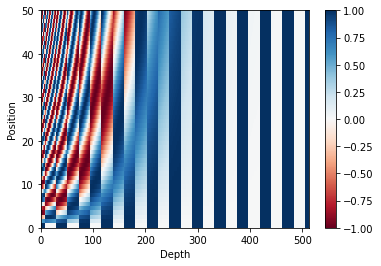

In [20]:
# 포지셔닝 벡터 시각화

sample_pos_encoding = PositionalEncoding(50,512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 스케일드 닷 프로덕트 어텐션 함수

In [21]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output



### 멀티 헤드 어텐션

In [22]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs


### 패딩 마스킹 구현

In [23]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

### 룩 어헤드 마스킹 구현

In [24]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

### 인코더 층

In [25]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 인코더 층 쌓기

In [26]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더 층

In [27]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 디코더 층 쌓기

In [28]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 트랜스포머 함수 정의

In [29]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 6. 모델 생성

In [47]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3138560     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 손실 함수

In [48]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 커스텀 된 학습률 (아담 옵티마이저 사용)

In [49]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

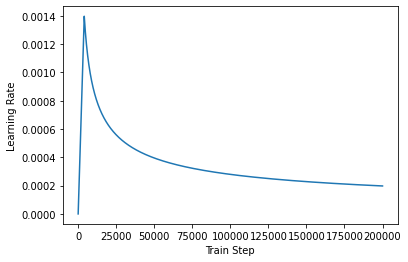

In [50]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 7. 모델 컴파일

In [51]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## 8. 모델 학습

In [52]:
#validation data 만들기

BATCH_SIZE = 64
BUFFER_SIZE = 5000     # 작업 시에 CPU가 처리하는 정보의 양

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.

val_ratio = int(len(data) * 0.2)
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions[:val_ratio],
        'dec_inputs': answers[:val_ratio, :-1]
    },
    {
        'outputs': answers[:val_ratio, 1:]
    },
))

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions[val_ratio:],
        'dec_inputs': answers[val_ratio:, :-1]
    },
    {
        'outputs': answers[val_ratio:, 1:]
    },
))

val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# train dataset shape 확인
print(questions[val_ratio:].shape)
print(answers[val_ratio:, :-1].shape)
print(answers[val_ratio:, 1:].shape)

(9457, 28)
(9457, 27)
(9457, 27)


In [54]:
EPOCHS = 50

hist = model.fit(train_dataset,
                 epochs=EPOCHS,
                 validation_data=val_dataset,
                 verbose=1)

Epoch 1/50
148/148 [==============================] - 15s 58ms/step - loss: 2.1709 - accuracy: 0.0331 - val_loss: 1.7924 - val_accuracy: 0.0448
Epoch 2/50
148/148 [==============================] - 7s 50ms/step - loss: 1.8507 - accuracy: 0.0667 - val_loss: 1.5024 - val_accuracy: 0.0692
Epoch 3/50
148/148 [==============================] - 7s 50ms/step - loss: 1.5745 - accuracy: 0.0722 - val_loss: 1.3408 - val_accuracy: 0.0707
Epoch 4/50
148/148 [==============================] - 8s 51ms/step - loss: 1.4364 - accuracy: 0.0754 - val_loss: 1.2823 - val_accuracy: 0.0745
Epoch 5/50
148/148 [==============================] - 7s 51ms/step - loss: 1.3541 - accuracy: 0.0802 - val_loss: 1.2472 - val_accuracy: 0.0767
Epoch 6/50
148/148 [==============================] - 7s 51ms/step - loss: 1.2789 - accuracy: 0.0841 - val_loss: 1.2216 - val_accuracy: 0.0794
Epoch 7/50
148/148 [==============================] - 7s 51ms/step - loss: 1.2024 - accuracy: 0.0896 - val_loss: 1.1961 - val_accuracy: 0.081

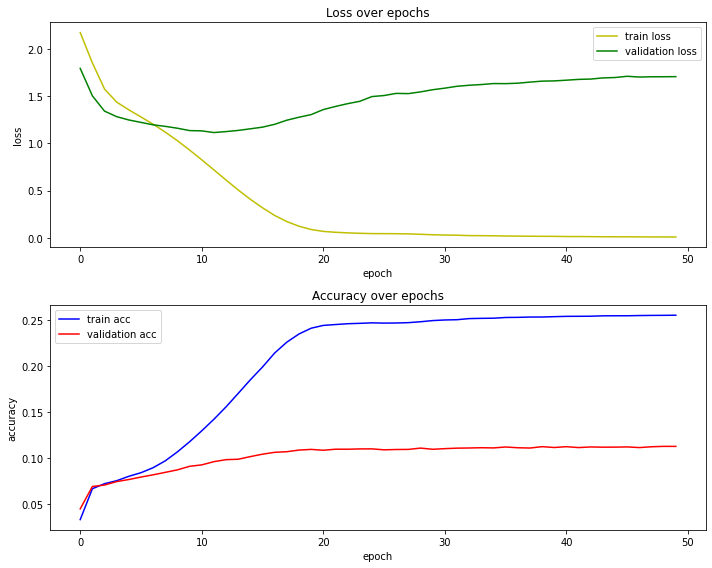

In [55]:
import matplotlib.pyplot as plt

# Subplot 생성 (2개의 그래프: 하나는 loss, 하나는 accuracy)
fig, (loss_ax, acc_ax) = plt.subplots(2, 1, figsize=(10, 8))

# 첫 번째 서브플롯: loss
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
loss_ax.set_title('Loss over epochs')

# 두 번째 서브플롯: accuracy
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'r', label='validation acc')
acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='best')
acc_ax.set_title('Accuracy over epochs')

# 그래프 표시
plt.tight_layout()  # 레이아웃 조정 (여백 자동 조정)
plt.show()


## 9. 챗봇 테스트 하기

새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.  
입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가한다.  
패딩 마스킹과 룩 어헤드 마스킹을 계산한다.  
디코더는 입력 시퀀스로부터 다음 단어를 예측한다.  
디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.  
END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.  

In [56]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [57]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [58]:
sentence_generation('지금 뭐해?')
sentence_generation('밖에 비 온다')
sentence_generation('노래 듣고 싶다')
sentence_generation('영화 재미 없다')

입력 : 지금 뭐해?
출력 : 수다떨고 영화보고 책보기 등등 다양하게 할 수 있어요 .
입력 : 밖에 비 온다
출력 : 저랑 이야기 해요 .
입력 : 노래 듣고 싶다
출력 : 전공에 관심이 많은가봐요 .
입력 : 영화 재미 없다
출력 : 웃을 때까지 이야기해 보죠


'웃을 때까지 이야기해 보죠'

결과 : 얼추 적당한 답변을 하는 것으로 보이지만 정확한 대답이 아님

epoch을 50회로 늘려서 훈련했음에도 성능이 좋아지지 않음  
-> 하이퍼파라미터 늘려서 실행해보기

## 2차 시도

하이퍼 파라미터 논문과 같게 진행  

NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수  
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원  
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수  
UNITS = 2048 # 피드 포워드 신경망의 은닉층의 크기  
DROPOUT = 0.3 # 드롭아웃의 비율

In [41]:
#모델 생성

tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 2048 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.3 # 드롭아웃의 비율

model2 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)


# 손실 함수 정의
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

# 옵티마이저 설정
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# 컴파일 설정

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])



#모델 학습
EPOCHS = 30

hist2 = model2.fit(train_dataset,
                 epochs=EPOCHS,
                 validation_data=val_dataset,
                 verbose=1)

# 체크포인트 정의
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=model2, optimizer=optimizer)

Epoch 1/30
148/148 [==============================] - 56s 263ms/step - loss: 2.0312 - accuracy: 0.0308 - val_loss: 1.5942 - val_accuracy: 0.0346
Epoch 2/30
148/148 [==============================] - 35s 238ms/step - loss: 1.6998 - accuracy: 0.0522 - val_loss: 1.3872 - val_accuracy: 0.0692
Epoch 3/30
148/148 [==============================] - 35s 238ms/step - loss: 1.5193 - accuracy: 0.0720 - val_loss: 1.3314 - val_accuracy: 0.0713
Epoch 4/30
148/148 [==============================] - 35s 239ms/step - loss: 1.4505 - accuracy: 0.0734 - val_loss: 1.3084 - val_accuracy: 0.0711
Epoch 5/30
148/148 [==============================] - 35s 238ms/step - loss: 1.4069 - accuracy: 0.0744 - val_loss: 1.3030 - val_accuracy: 0.0715
Epoch 6/30
148/148 [==============================] - 35s 239ms/step - loss: 1.3767 - accuracy: 0.0755 - val_loss: 1.2980 - val_accuracy: 0.0726
Epoch 7/30
148/148 [==============================] - 36s 240ms/step - loss: 1.3476 - accuracy: 0.0771 - val_loss: 1.2964 - val_ac

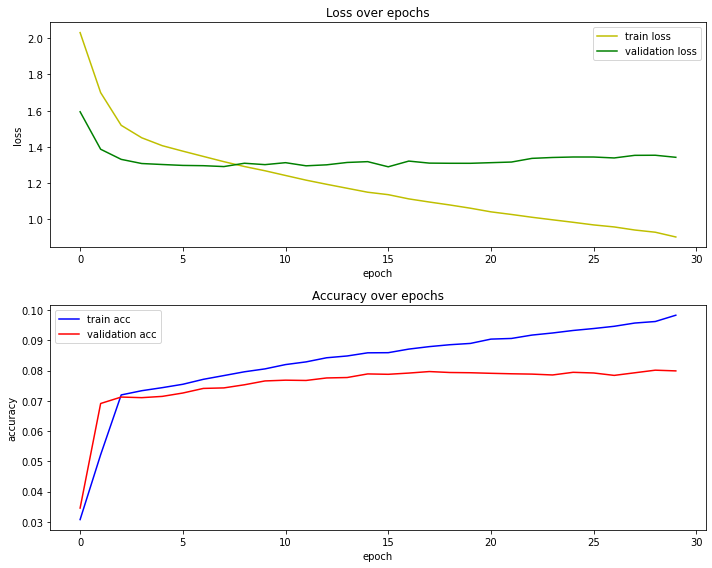

In [44]:
import matplotlib.pyplot as plt

# Subplot 생성 (2개의 그래프: 하나는 loss, 하나는 accuracy)
fig, (loss_ax, acc_ax) = plt.subplots(2, 1, figsize=(10, 8))

# 첫 번째 서브플롯: loss
loss_ax.plot(hist2.history['loss'], 'y', label='train loss')
loss_ax.plot(hist2.history['val_loss'], 'g', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
loss_ax.set_title('Loss over epochs')

# 두 번째 서브플롯: accuracy
acc_ax.plot(hist2.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist2.history['val_accuracy'], 'r', label='validation acc')
acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='best')
acc_ax.set_title('Accuracy over epochs')

# 그래프 표시
plt.tight_layout()  # 레이아웃 조정 (여백 자동 조정)
plt.show()


In [45]:
sentence_generation('지금 뭐해?')
sentence_generation('밖에 비 온다')
sentence_generation('노래 듣고 싶다')
sentence_generation('영화 재미 없다')

입력 : 지금 뭐해?
출력 : 수다떨고 영화보고 책보기 등등 다양하게 할 수 있어요 .
입력 : 밖에 비 온다
출력 : 쉬운 일이 아니죠 .
입력 : 노래 듣고 싶다
출력 : 노래 연습 꾸준히 해보세요 .
입력 : 영화 재미 없다
출력 : 영화 한 편 보세요 .


'영화 한 편 보세요 .'

결과 : 하이퍼 파라미터 늘려서 실행해본 결과, 오히려 성능이 좋지 않았다

### 3차 시도  

Dropout 비율 조정 및 EarlyStopping 추가해보기

In [64]:
#모델 생성

tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율


model2 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

# 컴파일 설정

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])



#모델 학습
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 30

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss',    # 검증 손실을 모니터링
                               patience=4,            # 3 에폭 동안 개선되지 않으면 훈련 종료
                               min_delta=0.01,        # 손실이 0.01 이상 개선되지 않으면 종료
                               restore_best_weights=True)  # 훈련 종료 후 가장 좋은 모델 가중치를 복원

# 모델 훈련 시 콜백 추가
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[early_stopping])

Epoch 1/30
148/148 [==============================] - 9s 53ms/step - loss: 0.0089 - accuracy: 0.2558 - val_loss: 1.7240 - val_accuracy: 0.1121
Epoch 2/30
148/148 [==============================] - 7s 50ms/step - loss: 0.0085 - accuracy: 0.2560 - val_loss: 1.7227 - val_accuracy: 0.1125
Epoch 3/30
148/148 [==============================] - 7s 51ms/step - loss: 0.0082 - accuracy: 0.2559 - val_loss: 1.7107 - val_accuracy: 0.1127
Epoch 4/30
148/148 [==============================] - 7s 51ms/step - loss: 0.0073 - accuracy: 0.2561 - val_loss: 1.7214 - val_accuracy: 0.1123
Epoch 5/30
148/148 [==============================] - 7s 50ms/step - loss: 0.0077 - accuracy: 0.2561 - val_loss: 1.7391 - val_accuracy: 0.1123
Epoch 6/30
148/148 [==============================] - 7s 51ms/step - loss: 0.0072 - accuracy: 0.2561 - val_loss: 1.7437 - val_accuracy: 0.1126
Epoch 7/30
148/148 [==============================] - 8s 51ms/step - loss: 0.0071 - accuracy: 0.2562 - val_loss: 1.7600 - val_accuracy: 0.1126

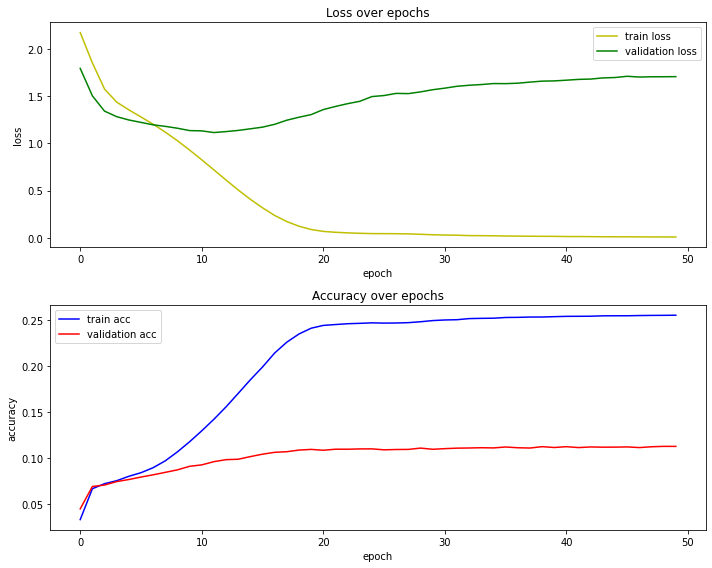

In [65]:
import matplotlib.pyplot as plt

# Subplot 생성 (2개의 그래프: 하나는 loss, 하나는 accuracy)
fig, (loss_ax, acc_ax) = plt.subplots(2, 1, figsize=(10, 8))

# 첫 번째 서브플롯: loss
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')
loss_ax.set_title('Loss over epochs')

# 두 번째 서브플롯: accuracy
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'r', label='validation acc')
acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='best')
acc_ax.set_title('Accuracy over epochs')

# 그래프 표시
plt.tight_layout()  # 레이아웃 조정 (여백 자동 조정)
plt.show()


In [67]:
sentence_generation('지금 뭐해?')
sentence_generation('밖에 비 온다')
sentence_generation('노래 듣고 싶다')
sentence_generation('영화 재미 없다')

입력 : 지금 뭐해?
출력 : 수다떨고 영화보고 책보기 등등 다양하게 할 수 있어요 .
입력 : 밖에 비 온다
출력 : 잘 이별의 끝일지도 몰라요 .
입력 : 노래 듣고 싶다
출력 : 지금 전화해보세요 .
입력 : 영화 재미 없다
출력 : 웃을 때까지 이야기해 보죠


'웃을 때까지 이야기해 보죠'

**회고**  

하이퍼 파라미터를 올려서 훈련하니 오히려 과적합되어 성능이 좋지 않았다.  
성능을 높이기 위해서 여러가지 실험을 해보았지만 문장의 형식만 갖출 뿐 대화가 이어지는 느낌이 들지 않았다  
퍼실님께 물어봤을 때 데이터셋이 단순해서 이러한 결과가 나올 수 있다는 답변을 들었다.  
더 성능을 높일 수 있는 방법을 고민해봐야겠다.